# Data Cleaning

In [1]:
import sys, os
sys.path.append('../')
import pandas as pd
from utils.cleaning import cleaning_pipeline, plot_boxplots
import warnings
warnings.filterwarnings("ignore")

# Data Ingestion

In [2]:
df = pd.read_csv("./Data/teste_indicium_precificacao.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (48894, 16)


,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# General Look at the Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [4]:
df.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Observations:
- The dataset contains missing values in four columns: `nome`, `host_name`, `ultima_review`, `reviews_por_mes`. The last two have the same amount of NaN values
- There are no duplicated rows
- It contains two Id columns, with `id` being the identifier of the ad and `host_id` being the identifier of who hosted the ad 
- `price` is the target, since the objective is to predict rent prices per night. Also, the minnimal value for this column is 0, which makes no sense.
- All numerical columns appear to be heavily skewed, with outliers. The column `minimo_noites` has a maximum value of 1250, implying that the host should rent the place for this number of nights at a minimum

### Impact:
- Missing data in the columns `ultima_review` and `reviews_por_mes` should be handled
- Both id columns, together with `host_name` must be dropped since they have no value
- Ads with a `price` of 0 will be removed, since the objective is to create a model to predict price. Free listings are not relevant here
- All numerical columns should be investigated to see if there are outliers that are so extreme, that the only explanation for them to be here is because of a typo or something of this nature

# Missing Data

In [7]:
# Identify rows where either "ultima_review" or "reviews_por_mes" is missing
missing_data = (df["ultima_review"].isna()) | (df["reviews_por_mes"].isna())
df[missing_data].shape

(10052, 16)

In [8]:
# Check the values of "numero_de_reviews" on the filtered dataset
filter_missing_df = df[missing_data]
filter_missing_df["numero_de_reviews"].value_counts()

numero_de_reviews
0    10052
Name: count, dtype: int64

### Observations:
- Everytime that `ultima_review` is a NaN value, so is `reviews_por_mes`
- `numero_de_reviews` confirms that there's no error in the dataset. Every time there's a missing value in those columns, `numero_de_reviews` is 0, meaning that the ad was never reviewed before

### Impact:
- Since `ultima_review` is in date format, and it's impossible to set a date for a review that never happened, this column will be dropped
- All missing values of `reviews_por_mes` will be replaced by 0, since `numero_de_reviews` is also 0 on every occasion

# Outilers

### Since "reviews_por_mes" has NaN values, they need to be handled before checking and manipulating the column regarding outliers

In [9]:
df["reviews_por_mes"].fillna(0, inplace=True)

Outliers in price: 2972 | Upper bound value: 334.0
Outliers in minimo_noites: 6607 | Upper bound value: 11.0
Outliers in numero_de_reviews: 6021 | Upper bound value: 58.5
Outliers in reviews_por_mes: 3312 | Upper bound value: 3.89
Outliers in calculado_host_listings_count: 7080 | Upper bound value: 3.5


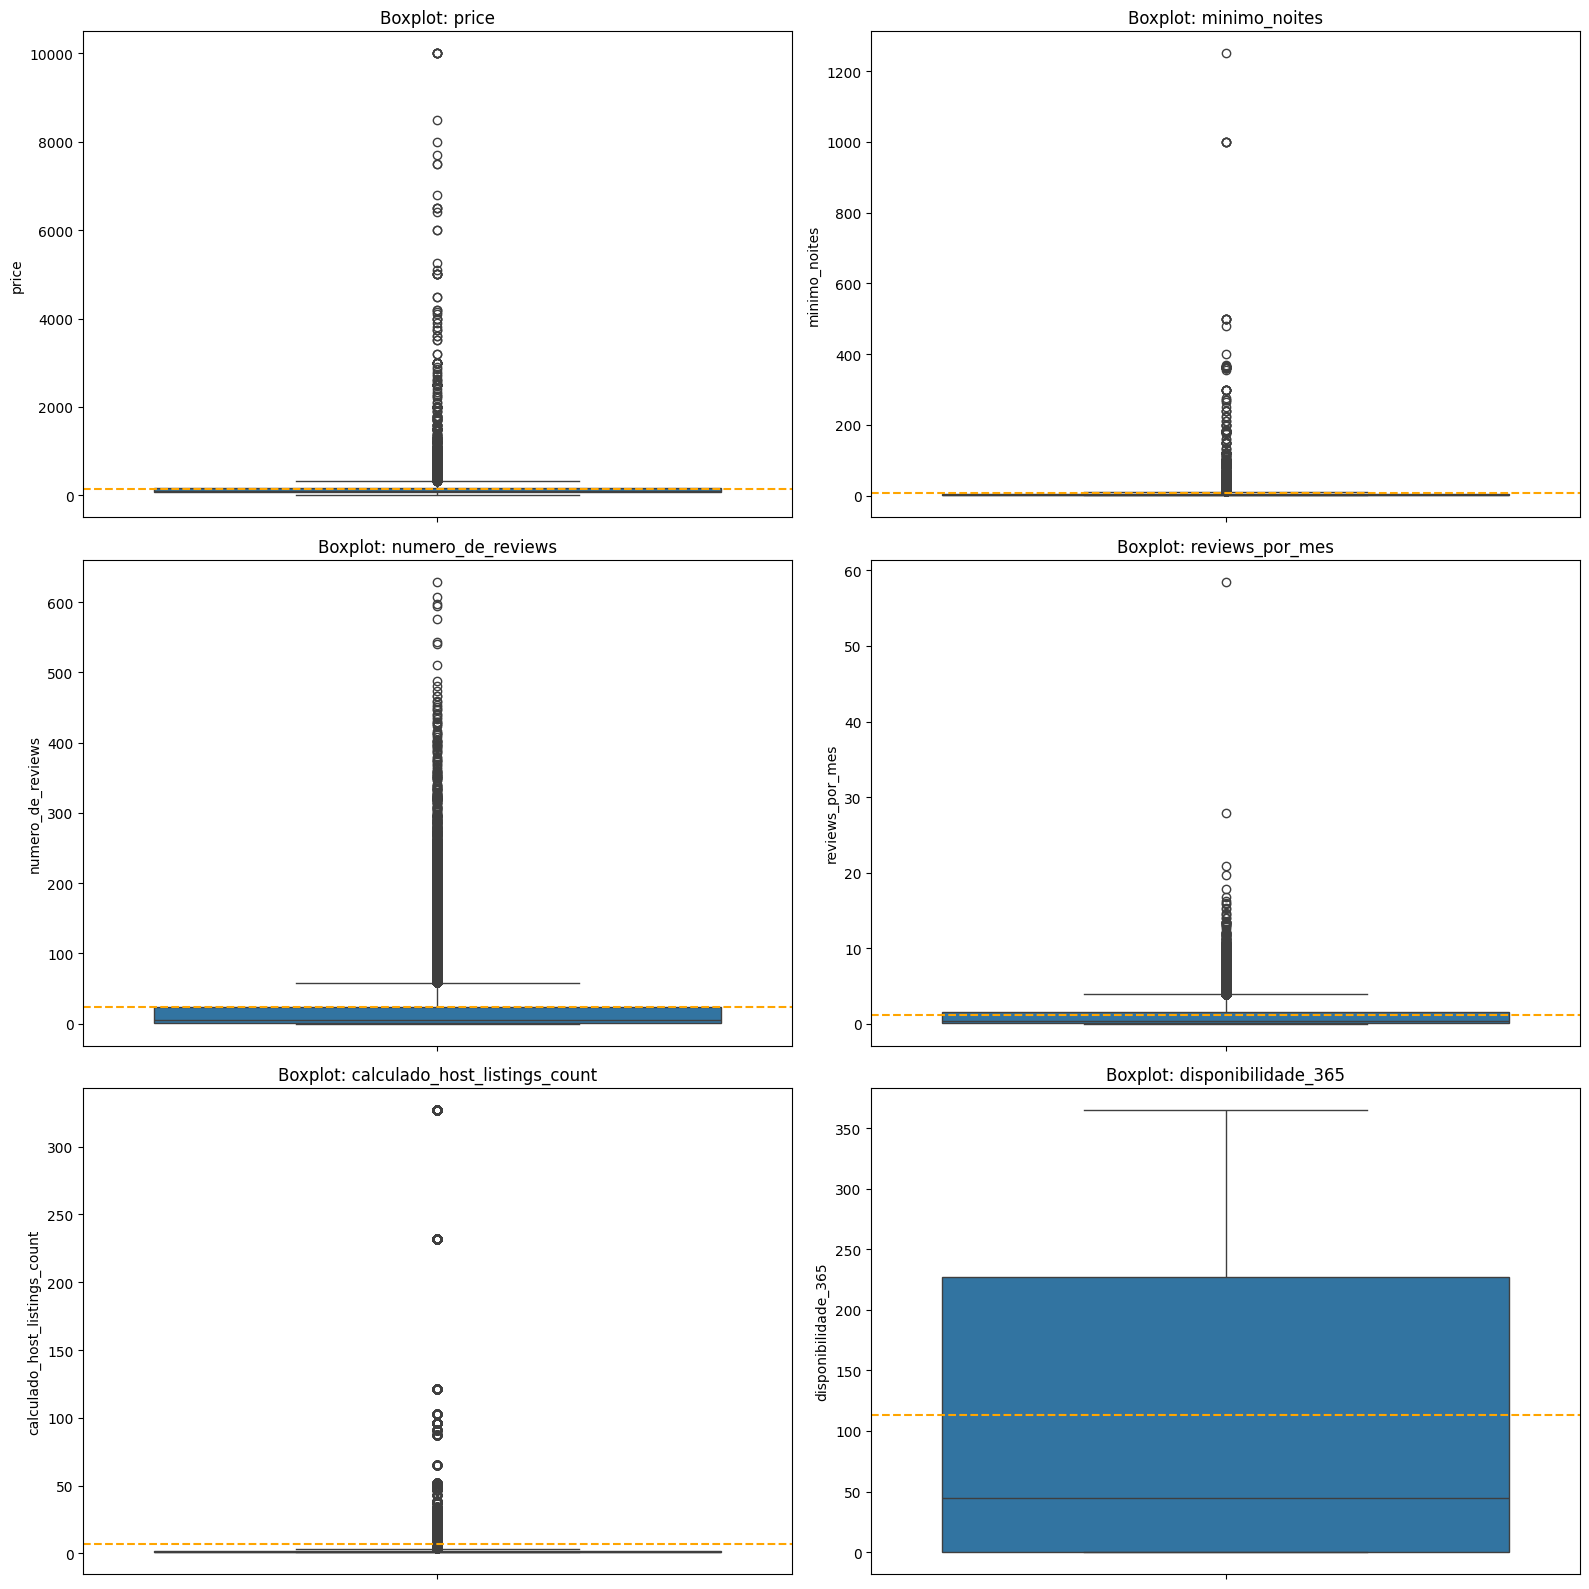

In [10]:
columns_to_drop = ["id", "host_id", "latitude", "longitude"]

# Plot a boxplot of each numerical column to check for outliers. Also, prints the amount of outliers and the value of the upper bound of the boxplot
plot_boxplots(df, columns_to_drop, 3, 2, (16, 16))

### Observations:
- `minimo_noites` showed a strange behavior. It shows ads that have a minimal time to stay more than 365, which is strange since 365 is the max number of days that the listing is available for booking
- `disponibilidade_365` is the only numerical column without outliers
- All other columns have extreme outliers that need to be dealt with, preventing them from negatively impacting the performance of the model

### Impact:
- All ads with `minimo_noites` above 365 will be dropped, ensuring that the column contains only realistic values
- For all other columns, the amount of outliers counted by the upper bound value is too high to drop them. So, the 99th percentile will be used to eliminate only the extreme outliers, improving the model's performance. Also, the rest of the outliers will be dealt with by applying statistical transformations to the columns, like log or cubic, to better handle them

In [11]:
# Dataframe showing the 99th percentile, how many times values above this treshold appear and how much of a percentage they represent
result = {}
columns_to_drop.extend(["minimo_noites", "disponibilidade_365"])
for col in df.drop(columns=columns_to_drop).select_dtypes("number"):
    result[col] = {"99th_percentile": df[col].quantile(0.99),
                   "count_above": (df[col] > df[col].quantile(0.99)).sum(),
                   "percentage_above": ((df[col] > df[col].quantile(0.99)).sum() / len(df)) * 100}
pd.DataFrame(result).T

,99th_percentile,count_above,percentage_above
price,799.0,474.0,0.969444
numero_de_reviews,214.0,480.0,0.981716
reviews_por_mes,6.8,486.0,0.993987
calculado_host_listings_count,232.0,327.0,0.668794


### Observations:
- Values above the 99th percentile appear very few times and represent less than 1% of the data. This is valid for all numeric columns checked

### Impact:
- All rows where there's a value above the 99th percentile in any of these columns will be dropped

In [12]:
# Calculate the 99th percentile for selected numerical columns
percentile_99 = df[["price", "numero_de_reviews", "reviews_por_mes", "calculado_host_listings_count"]].quantile(0.99)

# Create a mask by comparing each column with its 99th percentile value and filter the dataframe
mask = (df[percentile_99.index] <= percentile_99.values).all(axis=1)
df = df[mask]

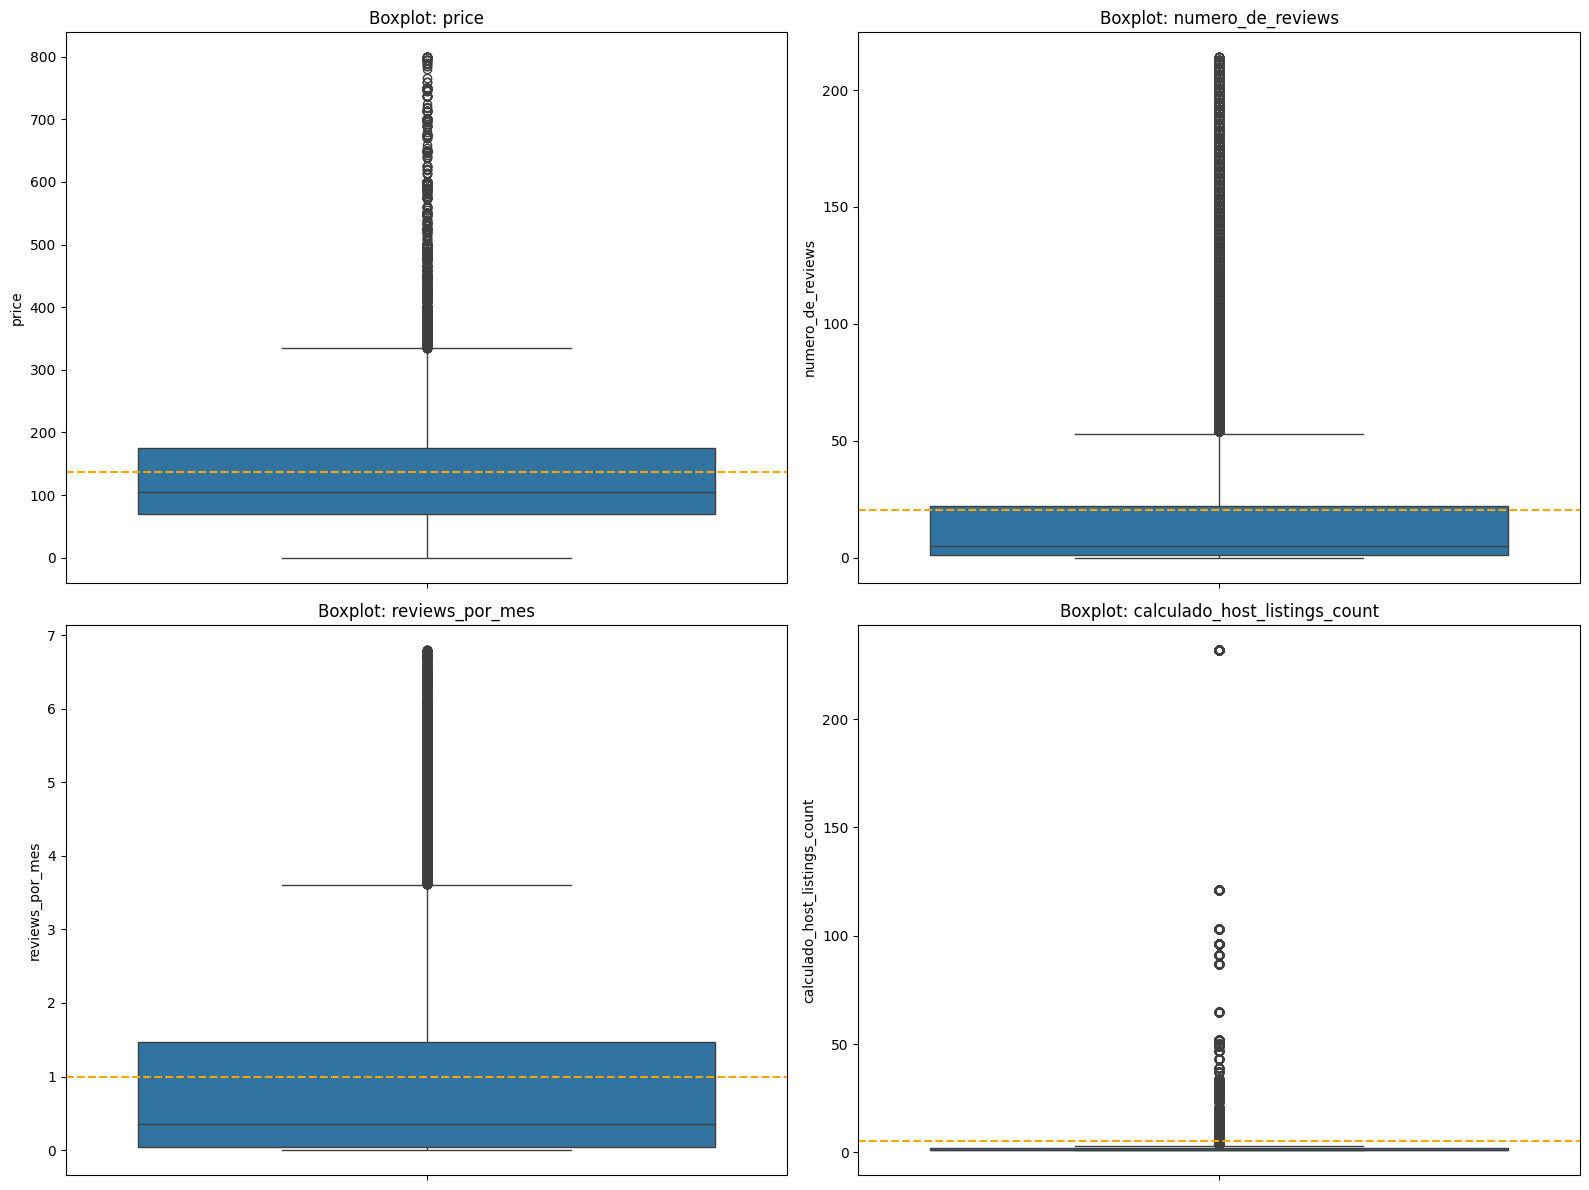

In [13]:
plot_boxplots(df, columns_to_drop, 2, 2, (16, 12), False)

### Observations:
- Apart from `calculado_host_listing_count`, there are no extreme outliers left in the columns. Latter, log or cubic transformations will be applied to all numerical columns, excluding the target, to better handle the remaining outliers

# Data Cleaning Pipeline

### Based on the analysis in this notebook, the following data cleaning steps will be taken:
- Remove the columns: `id`, `host_id`, `host_name` and `ultima_review`. The column `nome` will be used to determine if there's a pattern in the text for high-end places and its missing data will be filed with "No name"
- Drop all ads with a price of 0
- Fill all NaN values of `reviews_por_mes` with 0
- Remove all rows where `minimo_noites` is above 365
- Remove all extreme outliers from the numerical columns using the 99th percentile of each column

In [14]:
raw_data = pd.read_csv("./Data/teste_indicium_precificacao.csv")

In [15]:
columns_to_drop = ["id", "host_id", "host_name", "ultima_review"]
cleaning_pipeline(raw_data, columns_to_drop, "Data", "clean_teste_indicium_precificacao")